In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from pymatch.Matcher import Matcher
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import warnings
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

All the data sets were downloaded from IBM Cognos Analytics https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/10/new-base-samples-for-ibm-cognos-analytics-1113 .

In [2]:
#Demo - demographics data set with information about customer's gender, age, marital status and number of dependents.
demo = pd.read_excel('../00_raw_data/Telco_customer_churn_demographics.xlsx')
#Loca - information about customer's location: Country, State, City, and Zip code of the area.
loca = pd.read_excel('../00_raw_data/Telco_customer_churn_location.xlsx')
#Pop - number of residents in a particular zip code area.
pop = pd.read_excel('../00_raw_data/Telco_customer_churn_population.xlsx')
#Serv - all information related to a phone service: tenure (in months), phone service, internet type, monthly charge, etc.
serv = pd.read_excel('../00_raw_data/Telco_customer_churn_services.xlsx')
#Churn - information about customer satisfaction and churn (if churned, also includes a reason for churn)
churn = pd.read_excel('../00_raw_data/Telco_customer_churn_status.xlsx')

All of the data sets have a common unique ID: Customer ID which we will use to merge the datasets together.

In [3]:
#Merging and dropping columns that will not be used in the analysis.
df1 = pd.merge(demo, loca, how='inner', on='Customer ID',indicator=True)
df1 = df1.drop(['Count_x', 'Count_y', 'Country', 'State',
              'Under 30','Senior Citizen','Lat Long',
              'Latitude','Longitude','_merge'], axis=1)
df2 = pd.merge(df1, serv, how='inner', on='Customer ID',indicator=True)
df2 = df2.drop(['Count', 'Quarter','_merge'], axis=1)

df3 = pd.merge(df2, churn, how='inner', on='Customer ID',indicator=True)
df3 = df3.drop(['Count', 'Quarter','_merge','Churn Label'], axis=1)

df = pd.merge(df3, pop, how='inner', on='Zip Code',indicator=True)
df = df.drop(['ID','_merge','Churn Score'], axis=1)

Let's look more closely at our data now.

In [4]:
print ('Dimensions of the data set', df.shape)
df.head(5)

Dimensions of the data set (7043, 42)


,Customer ID,Gender,Age,Married,Dependents,...,Churn Value,CLTV,Churn Category,Churn Reason,Population
0,8779-QRDMV,Male,78,No,No,...,1,5433,Competitor,Competitor offered more data,68701
1,4737-AQCPU,Male,39,Yes,No,...,0,4658,NaN,NaN,68701
2,5043-TRZWM,Female,32,No,No,...,0,3503,NaN,NaN,68701
3,8165-CBKXO,Male,35,Yes,Yes,...,0,5748,NaN,NaN,68701
4,9979-RGMZT,Female,20,No,No,...,0,5545,NaN,NaN,68701


In [5]:
null=pd.DataFrame(df.isnull().sum()/df.shape[0])
null[null[0]>0]

,0
Churn Category,0.73463
Churn Reason,0.73463


Two categories that have missing data is, as expected, churn category and churn reason. In this case, missing values indicate that a user has not churned.

In [6]:
df=df.fillna('No churn')

In [7]:
df.describe()

,Age,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,...,Total Revenue,Satisfaction Score,Churn Value,CLTV,Population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,1.951867,32.386767,...,3034.379056,3.244924,0.265370,4400.295755,22139.603294
std,16.750352,0.962802,1856.767505,3.001199,24.542061,...,2865.204542,1.201657,0.441561,1183.057152,21152.392837
min,19.000000,0.000000,90001.000000,0.000000,1.000000,...,21.360000,1.000000,0.000000,2003.000000,11.000000
25%,32.000000,0.000000,92101.000000,0.000000,9.000000,...,605.610000,3.000000,0.000000,3469.000000,2344.000000
50%,46.000000,0.000000,93518.000000,0.000000,29.000000,...,2108.640000,3.000000,0.000000,4527.000000,17554.000000
75%,60.000000,0.000000,95329.000000,3.000000,55.000000,...,4801.145000,4.000000,1.000000,5380.500000,36125.000000
max,80.000000,9.000000,96150.000000,11.000000,72.000000,...,11979.340000,5.000000,1.000000,6500.000000,105285.000000


Data set has some outliers for instance, for variables "Total refunds" or "Total Extra Data Charges", but in general the data looks reasonable without any obvious errors such as negative values or extremely large entries.

In [8]:
#Creating the clean list of cities in the set (all written in the lower case without word "City" in the name).
temp = np.sort(df['City'].unique()).tolist()
cnt = 0

for item in temp:
    if 'city' in item.lower():
        cnt += 1

temp_remove_city = [a.replace('city', '').replace('City', '').strip() for a in temp]
temp_remove_city = [a.lower() for a in temp_remove_city]

Income is an essential variable for customer churn question. Our data set did not have a variable estimating customer's income. We, however, found another set with information about an average income in each city.

In [9]:
#read in mean income data
mean_income = pd.read_csv('/Users/iuliia/unifying-data-science-final-project-churn-analysis/00_raw_data/ACSST5Y2018.S1902_data_with_overlays_2020-04-21T172347.csv',
encoding = "ISO-8859-1", skiprows=(1,))
mean_income = mean_income[['City','S1902_C03_019E']]
mean_income.columns = ['City','mean_income']
mean_income.head(5)

,City,mean_income
0,Acalanes Ridge,53484
1,Acampo,70161
2,Acton,45253
3,Adelanto,12445
4,Adin,28639


In [10]:
print (f'The dataset has some {len([a for a in mean_income.mean_income.tolist() if not a.isnumeric()])} unusual entries in the "mean_income" column such as N or - that we want to remove.')


The dataset has some 54 unusual entries in the "mean_income" column such as N or - that we want to remove.


In [11]:
#delete city which has "N" & '-' for mean_income
def preproc_cityname(city_name):
    return city_name.replace('City', '').replace('city', '').replace('CDP', '').lower().split('(')[0].strip()

temp2 = np.array(mean_income).tolist()
temp2 = [[preproc_cityname(a[0]), a[1]] for a in temp2]
temp2 = [[a[0], int(a[1])] for a in temp2 if a[1] not in ['N', '-']]
mean_income_df = pd.DataFrame(data=temp2, columns=["City", "Mean_Income"])

Now we merge our main dataset with the income information.

In [12]:
df['City'] = df['City'].str.lower()
final = pd.merge(df,mean_income_df, how = 'inner', on = 'City')

### Data Preprocessing
**Missing values**

There is around 73% of missing data out of total records in *Churn Category* and *Churn Reason*. As the main project objective is to see what causal factors would lead to customer churn or not, the two variables are left for later analysis of identification of potential leaving customers if have time.

**Binary and multi-category variables**

The often-occuring "yes/no" binary response across different variables are modified to 1 and 0. For multi-category variables, dummy variables are created for each subcategory with 0 or 1 input. 

**Normalization on numeric variables**

As the numeric variables have different scales, normalization is performed on each numeric predictors by substracting the minimum value of that predictor and then divided by range value of that predictor. All numeric variables are adjusted to around the same scale this way.

In [13]:
# Creating treatment variable with/without offer
final['treated'] = 1
final['treated'][final['Offer'] == 'None'] = 0

#drop useless columns
final_drop = final.drop(['Customer ID','CLTV','City','Zip Code','Total Revenue', 'Customer Status','Churn Reason'],axis=1)

#replace all "Yes" to "1", "No" to "0"
final_drop = final_drop.replace('Yes',1)
final_drop = final_drop.replace('No',0)

#Categorical variables transform (Female='1', Male='0')
final_drop = final_drop.replace('Female',1)
final_drop = final_drop.replace('Male',0)

In [14]:
#continous: normalization
def normalization(data, normalization_list):
    
    for i in normalization_list:
        data[i] = (data[i] - data[i].min())/(data[i].max()-data[i].min())
    return data

In [15]:
#Creating a normalized final data set.
normalization_list = ['Tenure in Months','Avg Monthly Long Distance Charges','Avg Monthly GB Download','Monthly Charge','Total Charges','Total Long Distance Charges','Population', 'Mean_Income']
normalization(final_drop,normalization_list).head(3)

,Gender,Age,Married,Dependents,Number of Dependents,...,Churn Value,Churn Category,Population,Mean_Income,treated
0,0,78,0,0,0,...,1,Competitor,0.652488,0.181197,0
1,0,39,1,0,0,...,0,No churn,0.652488,0.181197,0
2,1,32,0,0,0,...,0,No churn,0.652488,0.181197,0


In [16]:
final_drop=final_drop.fillna('No churn')

### EDA

In [17]:
dummies=final_drop[['Internet Type','Contract','Payment Method','Churn Category', 'Offer']]

In [18]:
temp=pd.get_dummies(dummies)
final_drop=final_drop.assign(**temp)

In [19]:
#Check collinearity. Note: we display only the highly collinear values. To see the full correlation matrix, use df.corr() command.
corr = final_drop[['Tenure in Months', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges','Contract_Month-to-Month']].corr()
def color_negative_red(val):
    if val > 0.5 and val!=1:
        color = 'red' 
    elif val<-0.5:
        color='red'
    else:
        color='black'
    return 'color: %s' % color
highlited = corr.style.applymap(color_negative_red)
highlited 

,Tenure in Months,Monthly Charge,Total Charges,Total Long Distance Charges,Contract_Month-to-Month
Tenure in Months,1,0.245947,0.826428,0.670744,-0.627825
Monthly Charge,0.245947,1,0.648663,0.245187,0.0273106
Total Charges,0.826428,0.648663,1,0.608563,-0.444965
Total Long Distance Charges,0.670744,0.245187,0.608563,1,-0.416184
Contract_Month-to-Month,-0.627825,0.0273106,-0.444965,-0.416184,1


We also would like to know from what region data comes from. Note: for the sake of simplicity, we used Tableau for this visualization.

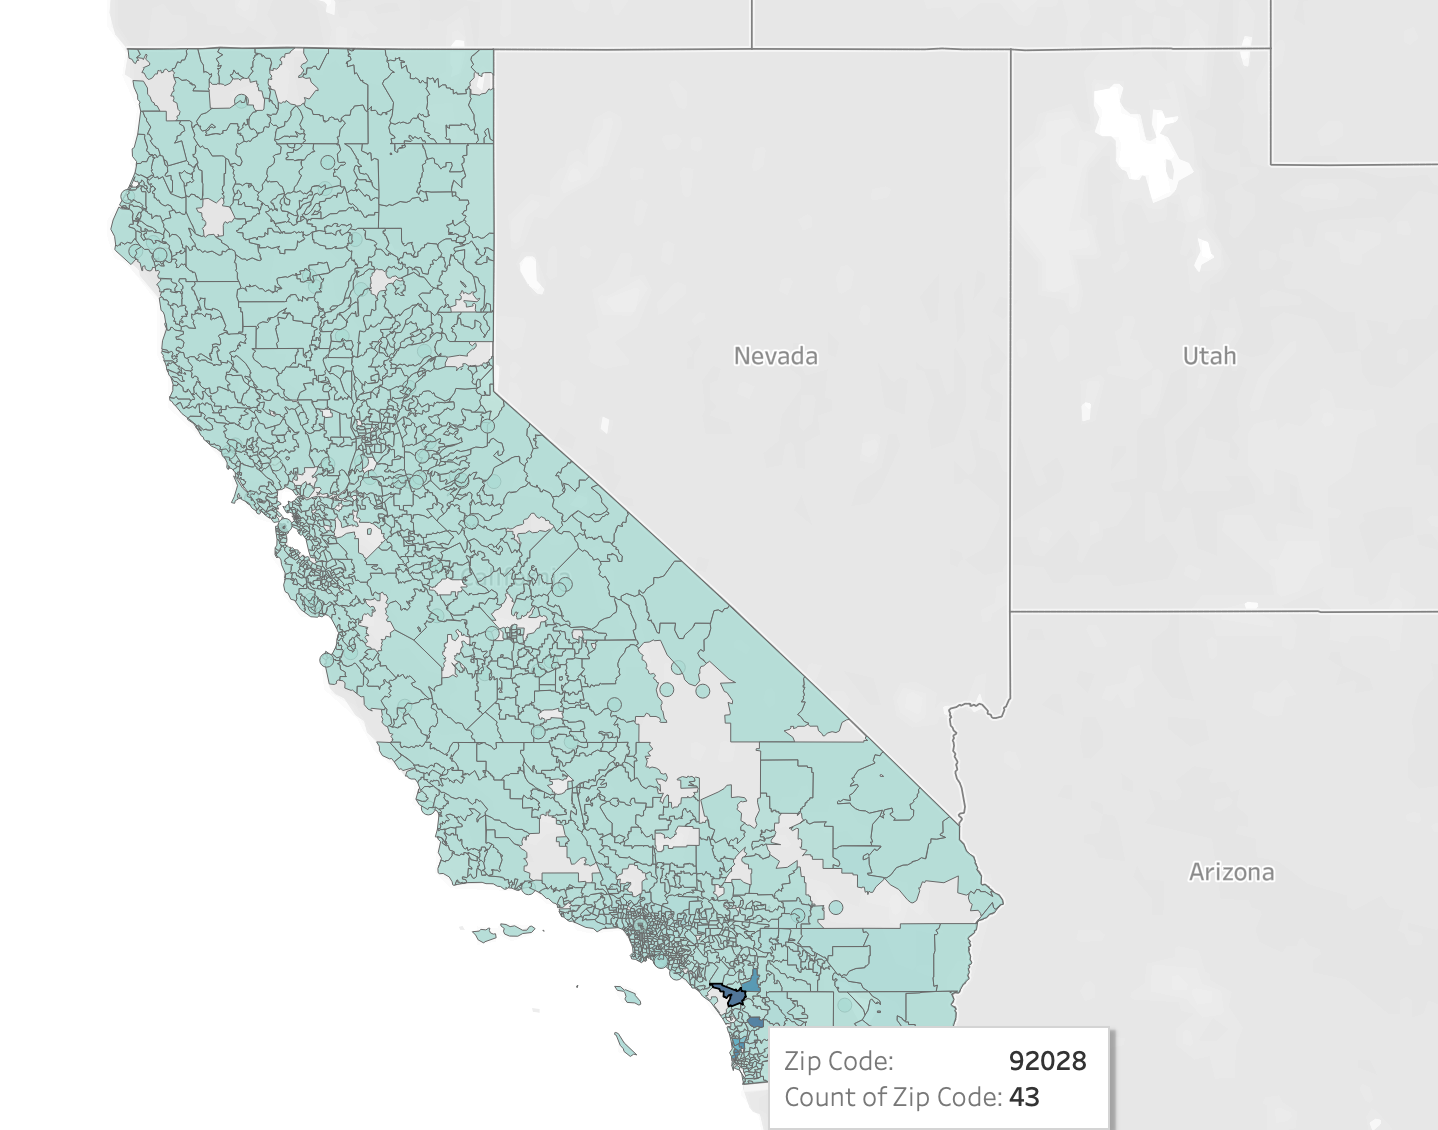

In [20]:
from IPython.display import Image
Image(filename = "california.png", width=700, height=600)

It is clear that all data was collected in California on average with 4 respondents per zip code. Fallbrook, CA, however, has the largest value of 43 respondents.
Let's start from investigating the top reasons for customers to churn.

Text(0, 0.5, 'Reason for churn')

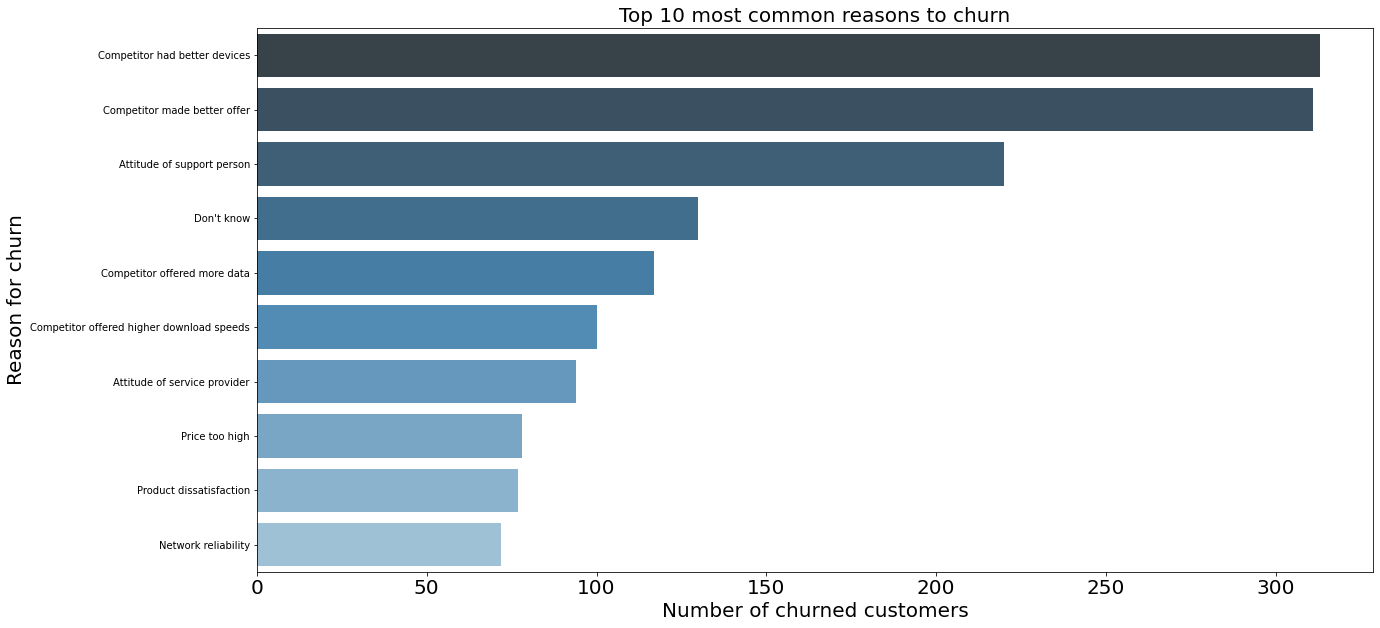

In [21]:
plt.figure(figsize=(20,10))
reasons=pd.DataFrame(churn.groupby('Churn Reason')['Customer ID'].count().nlargest(10))
y=reasons.index
x=reasons['Customer ID']
ax = sns.barplot(x=x, y=y,palette="Blues_d")
plt.xticks(fontsize=20)
plt.title('Top 10 most common reasons to churn',fontsize=20)
ax.set_xlabel('Number of churned customers', fontsize=20)
ax.set_ylabel('Reason for churn', fontsize=20)

The company has a variety of discount offers. Let's first check whether any of these offers are more effective than the others.

In [22]:
final_drop['Offer']=serv['Offer']
final_drop['Customer ID']=serv['Customer ID']
offers=pd.DataFrame(final_drop.groupby('Offer')['Customer ID'].count())
no_churn=pd.DataFrame(final_drop.groupby('Offer')['Churn Category_No churn'].sum())
offers=pd.DataFrame(pd.DataFrame(offers['Customer ID'] - no_churn['Churn Category_No churn'])[0]/offers['Customer ID']*100)

In [23]:
offers.columns=['% churned']
offers.sort_values(by='% churned', ascending=False)

,% churned
Offer,
Offer C,29.819277
Offer A,27.803738
None,27.505330
Offer B,27.064220
Offer E,25.306122
Offer D,24.705882


It seems like offer C is the least efficient and Offer D the most efficient as it has the lowest proportion of churned customers.
Let's check now how long the customers utilize the service.

Text(0.5, 26.200000000000003, 'Months of tenure')

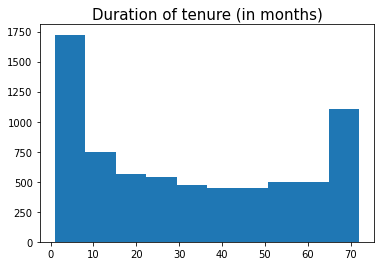

In [24]:
plt.hist(serv['Tenure in Months'])
plt.title('Duration of tenure (in months)',fontsize=15)
ax.set_xlabel('Months of tenure', fontsize=15)

Let's compare the difference in churn rates that used service for a year; 1-2 years; 2-3 years; 4-5 years; or more than five years.

Text(0, 0.5, 'Tenure')

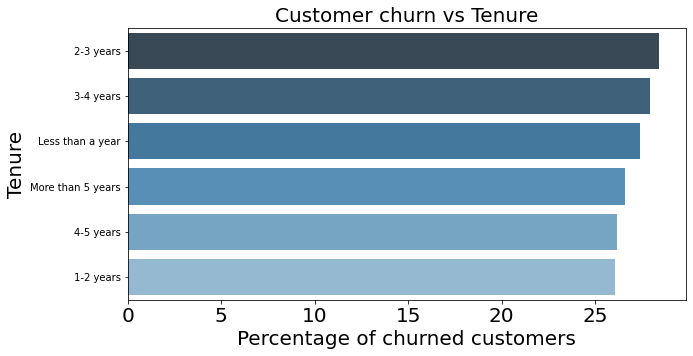

In [25]:
df=final_drop
df['Tenure']='Less than a year'
mask = (serv['Tenure in Months'] >=12) & (serv['Tenure in Months']<24)
df['Tenure'][mask] = '1-2 years'
mask = (serv['Tenure in Months'] >=24) & (serv['Tenure in Months']<36)
df['Tenure'][mask] = '2-3 years'
mask = (serv['Tenure in Months'] >=36) & (serv['Tenure in Months']<48)
df['Tenure'][mask] = '3-4 years'
mask = (serv['Tenure in Months'] >=48) & (serv['Tenure in Months']<60)
df['Tenure'][mask] = '4-5 years'
mask = (serv['Tenure in Months'] >=60) 
df['Tenure'][mask] = 'More than 5 years'
churn_tenure=pd.DataFrame((pd.DataFrame(df.groupby(['Tenure'])['Customer ID'].count())['Customer ID']-pd.DataFrame(df.groupby(['Tenure'])['Churn Category_No churn'].sum())['Churn Category_No churn'])/pd.DataFrame(df.groupby(['Tenure'])['Customer ID'].count())['Customer ID']*100)
churn_tenure=churn_tenure.sort_values(by=[0], ascending=False)
plt.figure(figsize=(10,5))
y=churn_tenure.index
x=churn_tenure[0]
ax = sns.barplot(x=x, y=y,palette="Blues_d")
plt.xticks(fontsize=20)
plt.title('Customer churn vs Tenure',fontsize=20)
ax.set_xlabel('Percentage of churned customers', fontsize=20)
ax.set_ylabel('Tenure', fontsize=20)

Interestingly, the churn rate does not change significantly over time. 
Let's monitor customer satisfaction rates now.

Text(0.5, 1.0, 'Satisfaction Scores')

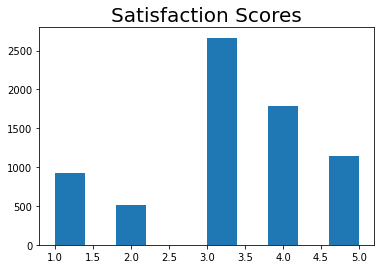

In [26]:
plt.hist(churn['Satisfaction Score'])
plt.title ('Satisfaction Scores',fontsize=20)

In [27]:
treatment=churn[churn['Churn Value']==1]
control=churn[churn['Churn Value']==0]
trt_sat=np.mean(treatment['Satisfaction Score'])
cntl_sat=np.mean(control['Satisfaction Score'])
print (f'Average satistdaction score for churned customers: {trt_sat:.2f} \nSatisfaction score for remained customers {cntl_sat:.2f}.')

Average satistdaction score for churned customers: 1.74 
Satisfaction score for remained customers 3.79.


Is there any difference in premium features that remained and churned users have?

In [28]:
df['Churn Reason']=churn['Churn Reason']
premium=df[['Customer ID','Online Security','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data','Churn Value','Churn Reason']]
premium_total=premium.drop(['Customer ID','Churn Reason','Churn Value'], axis=1)
premium['total']=np.sum(premium_total, axis=1)
treat_premium=premium[premium['Churn Value']==1]
control_premium=premium[premium['Churn Value']==0]
premium_features=['Online Security','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data']

for feature in premium_features:
    print (f'Feature: {feature}.\nAvg value for treatment group {np.mean(treat_premium[feature])}.\nAvg value for control group {np.mean(control_premium[feature])}')
    print (ttest_ind(treat_premium[feature],control_premium[feature]))
    print ('\n\n')

Feature: Online Security.
Avg value for treatment group 0.15527950310559005.
Avg value for control group 0.3331024930747922
Ttest_indResult(statistic=-13.706544317291769, pvalue=4.036523767226141e-42)



Feature: Premium Tech Support.
Avg value for treatment group 0.16459627329192547.
Avg value for control group 0.3340258541089566
Ttest_indResult(statistic=-12.995876844123266, pvalue=4.253748771622332e-38)



Feature: Streaming TV.
Avg value for treatment group 0.44161490683229815.
Avg value for control group 0.36334256694367495
Ttest_indResult(statistic=5.525433469679423, pvalue=3.426432696626884e-08)



Feature: Streaming Movies.
Avg value for treatment group 0.4403726708074534.
Avg value for control group 0.37119113573407203
Ttest_indResult(statistic=4.868422762457452, pvalue=1.154025694833617e-06)



Feature: Streaming Music.
Avg value for treatment group 0.3869565217391304.
Avg value for control group 0.34233610341643583
Ttest_indResult(statistic=3.1980784265583146, pvalue=0.00139

The difference is significant for all categories. However, the proportion is higher for churned users across all premium features except online security and tech support - we should pay additional attention to these features when do the analysis.

### Logistic regression: detect impactful features

In [36]:
X = df.drop(['Churn Value', 'Tenure','Customer ID','Offer','Internet Type','Contract','Churn Category_Attitude',
       'Churn Category_Competitor', 'Churn Category_Dissatisfaction',
       'Churn Category_No churn', 'Churn Category_Other',
       'Churn Category_Price', 'Churn Reason','Payment Method','Churn Category','Internet Service'],axis=1)
X['intercept'] = 1
y = final_drop['Churn Value']

logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()

         Current function value: 0.088262
         Iterations: 35


In [37]:
print(result.summary2())

                                   Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.849    
Dependent Variable:        Churn Value             AIC:                     1132.9004
Date:                      2020-04-28 17:27        BIC:                     1413.8721
No. Observations:          5942                    Log-Likelihood:          -524.45  
Df Model:                  41                      LL-Null:                 -3471.3  
Df Residuals:              5900                    LLR p-value:             0.0000   
Converged:                 0.0000                  Scale:                   1.0000   
No. Iterations:            35.0000                                                   
-------------------------------------------------------------------------------------
                                   Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------------------
Gend

In [101]:
df=final_drop[['Age','Number of Dependents','Referred a Friend','Number of Referrals','Tenure in Months',
                            'Phone Service','Online Security','Online Backup','Premium Tech Support','Monthly Charge',
                            'Total Refunds','Population','Satisfaction Score','treated']]

### Propensity score matching

In [102]:
#change variables' names: space to underscore
propensity = df.copy()
cols=[]
for col in propensity.columns:
    if col=='Contract_Month-to-Month':
        col='Contract_Month_to_Month'
        cols.append(col)
    else:
        cols.append(col.replace(" ", "_"))
    
propensity.columns=cols

#Treatment = customers with offer; control = customers without offer.
control = propensity[propensity['treated'] == 0]
treatment = propensity[propensity['treated'] == 1]

In [103]:
# Propensity score matching
from pymatch.Matcher import Matcher
m = Matcher(control, treatment, yvar = 'treated', 
            exclude = ['Churn_Value'])


np.random.seed(20)
m.fit_scores(balance=True, nmodels=200)

Formula:
treated ~ Age+Number_of_Dependents+Referred_a_Friend+Number_of_Referrals+Tenure_in_Months+Phone_Service+Online_Security+Online_Backup+Premium_Tech_Support+Monthly_Charge+Total_Refunds+Population+Satisfaction_Score
n majority: 3300
n minority: 2642
Fitting Models on Balanced Samples: 200\200
Average Accuracy: 53.26%


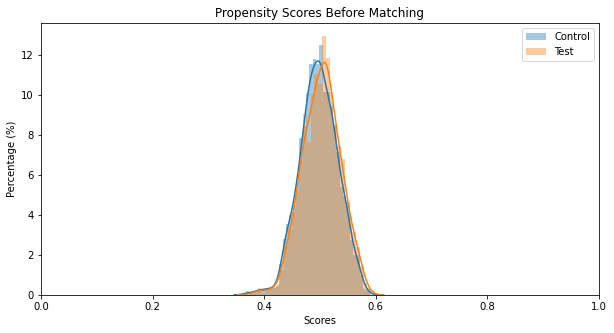

In [104]:
#Evaluate the common support of the treated and control groups
m.predict_scores() 
m.plot_scores()

In [105]:
#Obtain a matched sample using k:1 nearest neighbor method
m.match(method = "min", nmatches = 1)
records = m.record_frequency()
records

,freq,n_records
0,1,3577
1,2,426
2,3,166
3,4,42
4,5,27
5,6,9


In [106]:
m.assign_weight_vector()
matched = m.matched_data.sort_values("match_id")
matched.head(10)

,record_id,weight,Age,Number_of_Dependents,Referred_a_Friend,...,Population,Satisfaction_Score,treated,scores,match_id
1366,1784,0.25,24,0,1,...,0.033874,4,0,0.522114,0
2642,3300,1.00,20,0,0,...,0.652488,3,1,0.522128,0
2643,3301,1.00,74,1,1,...,0.528687,3,1,0.456311,1
721,889,1.00,55,3,0,...,0.208779,5,0,0.456292,1
485,611,1.00,73,0,1,...,0.232546,3,0,0.381058,2
2644,3302,1.00,71,3,0,...,0.451422,2,1,0.379243,2
2645,3303,1.00,34,0,0,...,0.451422,5,1,0.511942,3
966,1237,0.20,30,0,0,...,0.006336,3,0,0.511944,3
2646,3304,1.00,65,0,0,...,0.427589,1,1,0.444232,4
1075,1389,1.00,69,0,1,...,0.001406,3,0,0.444205,4


In [107]:
# save matched dataset csv
matched.to_csv('matched.csv')
matched.describe().to_csv('matched_summary.csv')

In [108]:
#Conduct a t-test between the treatment and control group using the matched data.
from scipy.stats import ttest_ind

matched_market_offer = matched[matched['treated'] == 1]
matched_no_market_offer = matched[matched['treated'] == 0]

In [109]:
covar_list = matched.drop(['record_id','weight','treated','scores','match_id'],axis=1).columns.tolist()
for covar in covar_list:
    ttest_p = ttest_ind(matched_market_offer[covar],matched_no_market_offer[covar])[1]
    print(f'P-value from t-test for {covar} between treatment and control group is {ttest_p:.5f}.')

P-value from t-test for Age between treatment and control group is 0.94378.
P-value from t-test for Number_of_Dependents between treatment and control group is 0.40988.
P-value from t-test for Referred_a_Friend between treatment and control group is 0.84681.
P-value from t-test for Number_of_Referrals between treatment and control group is 0.64015.
P-value from t-test for Tenure_in_Months between treatment and control group is 0.06696.
P-value from t-test for Phone_Service between treatment and control group is 0.32330.
P-value from t-test for Online_Security between treatment and control group is 0.27805.
P-value from t-test for Online_Backup between treatment and control group is 0.93118.
P-value from t-test for Premium_Tech_Support between treatment and control group is 0.63001.
P-value from t-test for Monthly_Charge between treatment and control group is 0.67171.
P-value from t-test for Total_Refunds between treatment and control group is 0.76242.
P-value from t-test for Population

Great! There is no significant difference between treatment and control groups.

At first, we fit a logistic regression using all variables; then select only statistically significant variables with the significance level<0.05. After that we used propensity score matching to ensure no baseline difference between treatment and control groups.
Now we fit a weighted linear regression to evaluate the effect of all features on customers' churn.

### Weighted Linear regression

In [110]:
matched['Churn_Value']=churn['Churn Value']

In [116]:
weight = matched['weight'].values
model=smf.wls('Churn_Value~Age+Number_of_Dependents+Referred_a_Friend+Number_of_Referrals+Tenure_in_Months+Phone_Service+Online_Security+Online_Backup+Premium_Tech_Support+Monthly_Charge+Total_Refunds+Population+treated+Satisfaction_Score',matched, weights = weight).fit()





In [124]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            Churn_Value   R-squared:                       0.603
Model:                            WLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     570.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:47:29   Log-Likelihood:                -1016.4
No. Observations:                5284   AIC:                             2063.
Df Residuals:                    5269   BIC:                             2161.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.7697      0.022     35.050      0.000       0.727       0.813
Age                     -0.0010      0.000     -4.093      0.000      -0.001      -0.001
Number_of_Dependents    -0.0098      0.004     -2.300      0.022      -0.018      -0.001
Referred_a_Friend        0.0157      0.011      1.367      0.172      -0.007       0.038
Number_of_Referrals     -0.0003      0.002     -0.153      0.878      -0.004       0.003
Tenure_in_Months         0.0118      0.014      0.860      0.390      -0.015       0.039
Phone_Service           -0.0114      0.014     -0.804      0.421      -0.039       0.016
Online_Security         -0.0003      0.010     -0.027      0.978      -0.019       0.019
Online_Backup            0.0100      0.010      1.049      0.294      -0.009       0.029
Premium_Tech_Support    -0.0021      0.010     -0.220      0.826      -0.021       0.017
Monthly_Charge          -0.0144      0.017     -0.857      0.392      -0.047       0.019
Total_Refunds           -0.0013      0.001     -2.493      0.013      -0.002      -0.000
Population              -0.0113      0.019     -0.584      0.559      -0.049       0.027
treated                 -0.7075      0.008    -89.170      0.000      -0.723      -0.692
Satisfaction_Score      -0.0020      0.004     -0.550      0.582      -0.009       0.005
==============================================================================
Omnibus:                     1194.862   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2267.230
Skew:                          -1.399   Prob(JB):                         0.00
Kurtosis:                       4.573   Cond. No.                         310.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
final=pd.DataFrame(np.exp(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef'])).head(22)
#To exclude intercept coefficient
final=final[1:]

In [123]:
final.sort_values(by='coef').head(3)

,coef
treated,0.492875
Monthly_Charge,0.985703
Phone_Service,0.988665


In [119]:
final.sort_values(by='coef').tail(3)

,coef
Online_Backup,1.010050
Tenure_in_Months,1.011870
Referred_a_Friend,1.015824


Offering customers discounted options has a great effect on the chances of a customer to churn. Customers who received a discount offer are 51% less likely to churn compare to all others. Offer D is one of the most effective solutions. We have not obtained any evidence that any other variables impact churn rates.